In [1]:
import pandas as pd
import os
from datetime import datetime as dt

from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

import pycountry as pc

import warnings
warnings.filterwarnings('ignore')

In [2]:
# classification targets
target_conf = 'armedconf'
target_escl = 'escalation'

# regression target
target_regr = 'deaths_all_pc'

# many features are made per-country
unit_of_analyis = 'isocode'

# start and end of test set
start_month_year = dt(2018, 1, 1)
end_month_year = dt(2023, 3, 1)

# time horizons forecase for
fwds = [1,3,6]

# target groupings
clsf_targets = [target_conf, target_escl]
regr_targets = [target_regr]

all_targets = clsf_targets + regr_targets

# algorithms used
algos = ['rf', 'xgb']

## Import predictions and join with true values

In [3]:
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))

### Re-create targets

Generated from all data, so need to drop training data.

In [4]:
df_og = pd.read_csv(os.path.abspath(parent_path + '/data/preprocessed_df.csv'))

df_og['month_year'] = pd.to_datetime(df_og['month_year'])

print(df_og.shape)
print(df_og.month_year.min(), df_og.month_year.max())
df_og.head()

(54915, 88)
2000-01-01 00:00:00 2023-03-01 00:00:00


,isocode,month_year,month,year,Country Name,deaths_all_pc,armedconf,escalation,past6,past12,...,isocode_4,isocode_5,isocode_6,isocode_7,f3_target_escl,f6_target_escl,f3_target_clsf,f6_target_clsf,f3_target_regr,f6_target_regr
0,AFG,2000-01-01,1,2000,Afghanistan,0.276314,True,0,0.276314,0.276314,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,2000-02-01,2,2000,Afghanistan,0.777290,True,1,1.053604,1.053604,...,0,0,0,1,1.0,1.0,1.0,1.0,1.701424,1.600231
2,AFG,2000-03-01,3,2000,Afghanistan,1.620053,True,0,2.673657,2.673657,...,0,0,0,1,0.0,1.0,1.0,1.0,1.581843,2.404725
3,AFG,2000-04-01,4,2000,Afghanistan,2.706927,True,0,5.380585,5.380585,...,0,0,0,1,0.0,1.0,1.0,1.0,1.160851,3.083456
4,AFG,2000-05-01,5,2000,Afghanistan,0.418548,True,0,5.799133,5.799133,...,0,0,0,1,1.0,1.0,1.0,1.0,1.499038,2.822271


In [5]:
def make_target_clsf(df: pd.DataFrame, shifter: int, target: str):

    # loop through each period and generate the shift variables (name doesn't matter, just interim columns to take max)
    for i in range(1, shifter+1):
        col_name = f'{target}{i}'
        df[col_name] = df.groupby(unit_of_analyis)[str(target)].shift(-i)

    # take the maximum for t periods forward and create the new variable & drop the shift variables
    df[f'{target}_f{shifter}'] = df[[f'{target}{i}' for i in range(1, shifter+1)]].max(axis=1, skipna=False)
    df = df.drop(columns=[f'{target}{i}' for i in range(1, shifter+1)])
    
    return(df)


def make_target_regr(df: pd.DataFrame, shifter: int, target: str): 

    # loop through each period and generate the temporary shift variables
    for i in range(1, shifter+1):
        col_name = f'{target}{i}'
        df[col_name] = df.groupby(unit_of_analyis)[str(target)].shift(-i)

    # take the mean for t periods forward and create the new variable &
    df[f'{target}_f{shifter}'] = df[[f'{target}{i}' for i in range(1, shifter+1)]].mean(axis=1, skipna=False)

    # 
    df = df.drop(columns=[f'{target}{i}' for i in range(1, shifter+1)])
    
    return(df)

In [6]:
# demonstrating the make_target functions
df_targets = df_og.copy()

# generate targets
for fwd in fwds:
    for target in clsf_targets:
        df_targets = make_target_clsf(df_targets, fwd, target)
    
    for target in regr_targets:
        df_targets = make_target_regr(df_targets, fwd, target)

# check it worked
fwd = 3
df_targets.loc[df_targets['isocode'] == 'BFA', ['isocode', 'Country Name', 'month_year',  'armedconf',  f'{target_escl}_f{fwd}', f'{target_conf}_f{fwd}','deaths_all_pc', f'{target_regr}_f{fwd}']][-8:]

,isocode,Country Name,month_year,armedconf,escalation_f3,armedconf_f3,deaths_all_pc,deaths_all_pc_f3
43378,BFA,Burkina Faso,2022-08-01,True,0.0,1.0,1.475068,0.754125
43379,BFA,Burkina Faso,2022-09-01,True,0.0,1.0,0.868751,0.758649
43380,BFA,Burkina Faso,2022-10-01,True,0.0,1.0,0.475098,0.600283
43381,BFA,Burkina Faso,2022-11-01,True,1.0,1.0,0.918524,1.010527
43382,BFA,Burkina Faso,2022-12-01,True,1.0,1.0,0.882326,1.561038
43383,BFA,Burkina Faso,2023-01-01,False,NaN,NaN,0.000000,NaN
43384,BFA,Burkina Faso,2023-02-01,True,NaN,NaN,2.149255,NaN
43385,BFA,Burkina Faso,2023-03-01,True,NaN,NaN,2.533858,NaN


In [7]:
df_targets = df_targets.loc[df_targets['month_year'] >= start_month_year]

print(df_targets.shape)
df_targets.columns

(12411, 97)


Index(['isocode', 'month_year', 'month', 'year', 'Country Name',
       'deaths_all_pc', 'armedconf', 'escalation', 'past6', 'past12', 'past60',
       'past120', 'armedconf_since', 'deaths_stock', 'share_events_1',
       'share_events_2', 'share_events_3', 'share_events_4', 'share_events_5',
       'share_events_6', 'share_events_7', 'share_events_8', 'share_events_9',
       'share_events_10', 'share_events_11', 'share_events_12',
       'share_events_13', 'share_events_14', 'share_events_15',
       'share_events_16', 'share_events_17', 'share_events_18',
       'share_events_19', 'share_events_20', 'share_events_gov',
       'share_events_opp', 'norm_total_events', 'event_share_1_stock',
       'event_share_2_stock', 'event_share_3_stock', 'event_share_4_stock',
       'event_share_5_stock', 'event_share_6_stock', 'event_share_7_stock',
       'event_share_8_stock', 'event_share_9_stock', 'event_share_10_stock',
       'event_share_11_stock', 'event_share_12_stock', 'event_share_1

### Import predictions

All are joined into a single data frame.

In [8]:
df_preds = pd.read_csv(os.path.abspath(path + f'/tree_based_pred/Final/predictions_rf_f1_escalation.csv'))
df_preds = df_preds[['isocode', 'month_year']]
df_preds['month_year'] = pd.to_datetime(df_preds['month_year'])

print(df_preds.shape, df_targets.shape)
print(df_preds.month_year.min(), df_preds.month_year.max())
print(df_targets.month_year.min(), df_targets.month_year.max())

df_preds.head()

(12411, 2) (12411, 97)
2018-01-01 00:00:00 2023-03-01 00:00:00
2018-01-01 00:00:00 2023-03-01 00:00:00


,isocode,month_year
0,AFG,2018-01-01
1,AGO,2018-01-01
2,ALB,2018-01-01
3,ARE,2018-01-01
4,ARG,2018-01-01


In [9]:
for algo in algos:
    for fwd in fwds:
        for target in all_targets: # all_targets

            df_temp = pd.read_csv(os.path.abspath(path + f'/tree_based_pred/Final/predictions_{algo}_f{fwd}_{target}.csv'))
            df_temp.drop(columns=['Unnamed: 0'], inplace=True)
            
            df_temp['month_year'] = pd.to_datetime(df_temp['month_year'], format='%Y-%m-%d')
            df_temp.sort_values(by=['month_year', 'isocode'], inplace=True)
            
            print(df_temp.shape, df_temp.month_year.min(), df_temp.month_year.max())
            
            #print(df_temp.columns )
            #df_preds = pd.concat([df_preds, df_temp], axis=1)

            df_preds = df_preds.merge(df_temp, how='left', on=['isocode', 'month_year'])

(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00


In [10]:
df_preds = df_preds.loc[:,~df_preds.T.duplicated(keep='first')]

print(df_preds.shape)
#df_preds.columns
df_preds.head(2)

(12411, 56)


,isocode,month_year,pred_armedconf_rf_f1_all,pred_armedconf_rf_f1_hs,pred_armedconf_rf_f1_tx,pred_escalation_rf_f1_all,pred_escalation_rf_f1_hs,pred_escalation_rf_f1_tx,pred_deaths_all_pc_rf_f1_all,pred_deaths_all_pc_rf_f1_hs,...,pred_deaths_all_pc_xgb_f3_tx,pred_armedconf_xgb_f6_all,pred_armedconf_xgb_f6_hs,pred_armedconf_xgb_f6_tx,pred_escalation_xgb_f6_all,pred_escalation_xgb_f6_hs,pred_escalation_xgb_f6_tx,pred_deaths_all_pc_xgb_f6_all,pred_deaths_all_pc_xgb_f6_hs,pred_deaths_all_pc_xgb_f6_tx
0,AFG,2018-01-01,0.988908,0.991190,0.958227,0.405951,0.114284,0.763412,11.127582,11.223889,...,3.572988,1.000000,0.999882,1.000000,0.989187,0.997928,0.999490,2.151273,2.929380,2.874567
1,AGO,2018-01-01,0.210516,0.235263,0.351255,0.608128,0.714963,0.314381,0.009906,0.008070,...,0.153685,0.017353,0.001365,0.025607,0.998660,0.984795,0.991863,0.192119,0.187882,0.188585


In [11]:
print('armed conflicts:', df_og[target_conf].sum())
print('perc of observ.:', df_og[target_conf].sum()/len(df_og)*100)

## with old preprocessing
# armed conflicts: 7144
# perc of observ.: 8.94397496087637

armed conflicts: 4594
perc of observ.: 8.36565601383957


### Join targets & predictions

Single data frame from which to generate metrics.

In [58]:
df_targ = df_targets.copy()
df_pred = df_preds.copy()

In [59]:
# ensure same order or sorting
df_targ.sort_values(by=['month_year', 'isocode'], inplace=True)
df_targ.reset_index(drop=True, inplace=True)
df_targ['month_year'] = pd.to_datetime(df_targ['month_year'], format='%Y-%m-%d')

# important to reset indices so that concatenation does not genrate additional rows
df_targ.reset_index(inplace=True) 
df_pred.reset_index(inplace=True)

# check same length
print(df_targ.shape, df_pred.shape)

# concatenate the two dataframes
#df_joined = pd.concat([df_targ, df_pred], axis=1)
df_joined = df_targ.merge(df_pred, how='left', on=['isocode', 'month_year'])

df = df_joined.copy()

df = df.loc[:,~df.T.duplicated(keep='first')]
df.drop(columns=['index_x'], inplace=True)

print(df.shape)
df.head(2)

(12411, 98) (12411, 57)
(12411, 151)


,isocode,month_year,month,year,Country Name,deaths_all_pc,armedconf,escalation,past6,past12,...,pred_deaths_all_pc_xgb_f3_tx,pred_armedconf_xgb_f6_all,pred_armedconf_xgb_f6_hs,pred_armedconf_xgb_f6_tx,pred_escalation_xgb_f6_all,pred_escalation_xgb_f6_hs,pred_escalation_xgb_f6_tx,pred_deaths_all_pc_xgb_f6_all,pred_deaths_all_pc_xgb_f6_hs,pred_deaths_all_pc_xgb_f6_tx
0,AFG,2018-01-01,1,2018,Afghanistan,4.838255,True,1,30.689119,55.771793,...,3.572988,1.000000,0.999882,1.000000,0.989187,0.997928,0.999490,2.151273,2.929380,2.874567
1,AGO,2018-01-01,1,2018,Angola,0.000000,False,0,0.012864,0.085440,...,0.153685,0.017353,0.001365,0.025607,0.998660,0.984795,0.991863,0.192119,0.187882,0.188585


In [131]:
# export for the map

# historical_vars = ['deaths_all_pc', 'armedconf', 'escalation', 'armedconf_since', 'deaths_stock', 'past6', 'past12', 'past60', 'past120',
#                    'share_state_deaths', 'share_nonstate_deaths', 'share_onesided_deaths', 'share_civilian_deaths',
#                    'refugees_in', 'refugees_out', 'neighbor_conflict']

# event_shares = ['share_events_{}'.format(i) for i in range(1, 21)] 
# event_share_stock = ['event_share_{}_stock'.format(i) for i in range(1, 21)]
# event_share_actor = ['share_events_gov', 'share_events_opp']
# event_total = ['norm_total_events']
# gdelt_admin1 = ['num_regions', 'Adm1_Max', 'Adm1_Mean', 'Adm1_Median']
# clusters = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3']
# text_gdelt_vars = event_shares + event_share_stock + event_share_actor + event_total + gdelt_admin1 + clusters
# other_vars = ['month_sin', 'month_cos', 'isocode_0','isocode_1','isocode_2','isocode_3','isocode_4','isocode_5','isocode_6','isocode_7'] 
# lstm_vars = ['f3_target_escl','f6_target_escl','f3_target_clsf','f6_target_clsf','f3_target_regr','f6_target_regr']


#df = df.drop(columns = historical_vars + text_gdelt_vars + other_vars + lstm_vars)
#df.to_csv(os.path.abspath(path + f'/tree_based_pred/Final/df_tree_based_joined.csv'), index=False)

## Metrics helper functions

In [17]:
# Allows us to obtain the predictions for a given target and original shifted data

def get_tar_pred(df: pd.DataFrame() , fwd: int, model: str, start_time: dt, target: str, algo: str):
    
    target_col = f'{target}_f{fwd}'
    pred_col = f'pred_{target}_{algo}_f{fwd}_{model}'

    df = df[[unit_of_analyis, 'month_year', target_col, pred_col]] 


    #df['month_year'] = pd.to_datetime(df['date_str'])
    #df = df[df.month_year >= start_time]
        
    df = df.dropna()

    y_preds = df[pred_col]
    y_trues = df[target_col]


    return y_trues, y_preds



In [18]:
# different levels forward will have different shapes due to NaN values being dropped
exmpl_df = pd.DataFrame(get_tar_pred(df, 6, 'tx', start_month_year, target_conf, 'rf'))

print(exmpl_df.shape)
#exmpl_df.head(2)

(2, 11229)


In [19]:
def get_roc_pr(df_og: pd.DataFrame, fwd: int, target: str, models: list, staryearid, algo = str): #binary=True, plot=True
    """Function to return the roc and pr values for a given target, level and forward period"""
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    for model in models:

        y_true, y_pred = get_tar_pred(df=df_og, fwd=fwd, model=model,start_time=staryearid, target=target,
                                        algo = algo)
    
        roc = roc_auc_score(y_true, y_pred)
        pr = average_precision_score(y_true, y_pred)
    
        # Compute the FPR & TPR and calculate the AUC
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        y_pred_binary = (y_pred > 0.5).astype(int)
        # Compute precision, recall, and thresholds for PR curve
        precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred)
    
        print('Model:', model)
        print('ROC:', round(roc, 3), 'Precision:', round(pr, 3))
        
        # Generate classification report
        class_report = classification_report(y_true, y_pred_binary)
        print('\nClassification Report:\n', class_report)
    
        # Plot ROC curve
        axs[0].plot(fpr, tpr, lw=2, label=f'ROC curve {model} (area = {roc_auc:.2f})')
    
        # Plot precision-recall curve
        axs[1].plot(recall, precision, lw=2, label=f'Precision-Recall curve {model} (prec: {pr:.2f})')
    
        axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs[0].set_xlim([0.0, 1.0])
        axs[0].set_ylim([0.0, 1.05])
        axs[0].set_xlabel('False Positive Rate (FP/(FP+TN))')
        axs[0].set_ylabel('True Positive Rate/Recall (TP/(TP+FN))')
        axs[0].set_title(f'ROCs for {target} {fwd} month(s) ahead')
        axs[0].legend(loc="lower right")
        
        axs[1].set_xlabel('Recall (TP/(TP+FN))')
        axs[1].set_ylabel('Precision (TP/(TP+FP))')
        axs[1].set_title('Precision-Recall Curve')
        axs[1].legend(loc="lower left")
        
        plt.tight_layout()
    fig.savefig(path + f'/tree_based_pred/Final/curves/ROC_{target}_{algo}_f{fwd}.png') #path + ''  + 

    #/Users/margheritaphilipp/Documents/GitHub/thesis/models/tree_based_pred/Final/curves
    plt.show()

    


## ROC and precision re-call curves (for classification)

In [20]:
os.getcwd() 

'/Users/margheritaphilipp/Documents/GitHub/thesis/models'

TARGET: armedconf f1
Model: all
ROC: 0.983 Precision: 0.896

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     10962
         1.0       0.59      0.95      0.73      1252

    accuracy                           0.93     12214
   macro avg       0.79      0.94      0.85     12214
weighted avg       0.95      0.93      0.94     12214

Model: tx
ROC: 0.956 Precision: 0.784

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.91      0.95     10962
         1.0       0.53      0.87      0.65      1252

    accuracy                           0.91     12214
   macro avg       0.75      0.89      0.80     12214
weighted avg       0.94      0.91      0.92     12214

Model: hs
ROC: 0.983 Precision: 0.901

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.92      0.96     10962
         1.0       0.59   

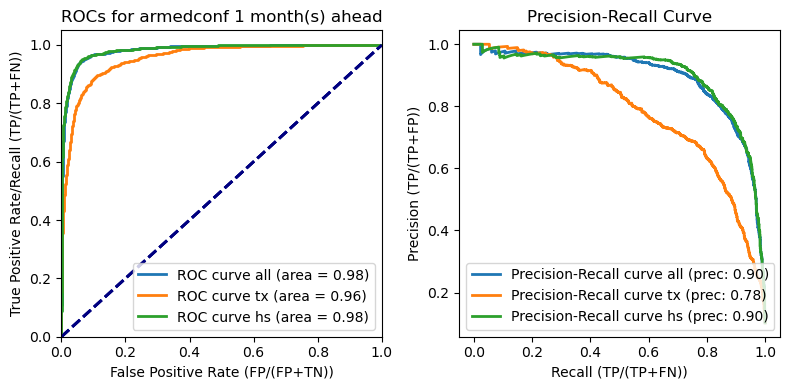

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: armedconf f3
Model: all
ROC: 0.975 Precision: 0.911

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     10225
         1.0       0.67      0.92      0.77      1595

    accuracy                           0.93     11820
   macro avg       0.83      0.92      0.86     11820
weighted avg       0.94      0.93      0.93     11820

Model: tx
ROC: 0.943 Precision: 0.788

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94     10225
         1.0       0.58      0.83      0.68      1595

    accuracy                           0.90     11820
   macro avg       0.78      0.87      0.81     11820
weighted avg       0.92      0.90      0.90     11820

Model: hs
ROC: 0.977 Precision: 0.921

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99   

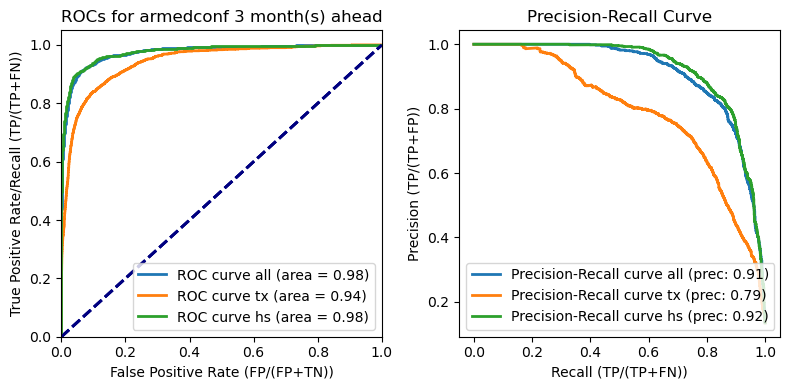

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: armedconf f6
Model: all
ROC: 0.967 Precision: 0.901

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.92      0.95      9429
         1.0       0.69      0.89      0.77      1800

    accuracy                           0.92     11229
   macro avg       0.83      0.90      0.86     11229
weighted avg       0.93      0.92      0.92     11229

Model: tx
ROC: 0.932 Precision: 0.783

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.89      0.92      9429
         1.0       0.59      0.82      0.68      1800

    accuracy                           0.88     11229
   macro avg       0.77      0.85      0.80     11229
weighted avg       0.90      0.88      0.89     11229

Model: hs
ROC: 0.97 Precision: 0.912

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98    

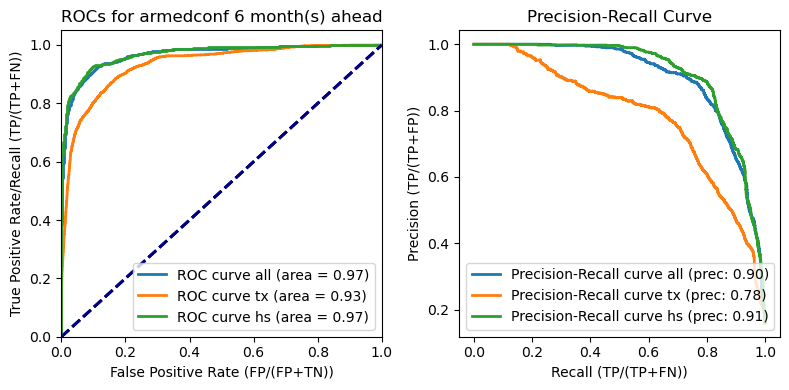

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: armedconf f1
Model: all
ROC: 0.983 Precision: 0.904

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     10962
         1.0       0.90      0.78      0.83      1252

    accuracy                           0.97     12214
   macro avg       0.94      0.88      0.91     12214
weighted avg       0.97      0.97      0.97     12214

Model: tx
ROC: 0.972 Precision: 0.854

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     10962
         1.0       0.90      0.62      0.73      1252

    accuracy                           0.95     12214
   macro avg       0.93      0.80      0.85     12214
weighted avg       0.95      0.95      0.95     12214

Model: hs
ROC: 0.983 Precision: 0.905

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98   

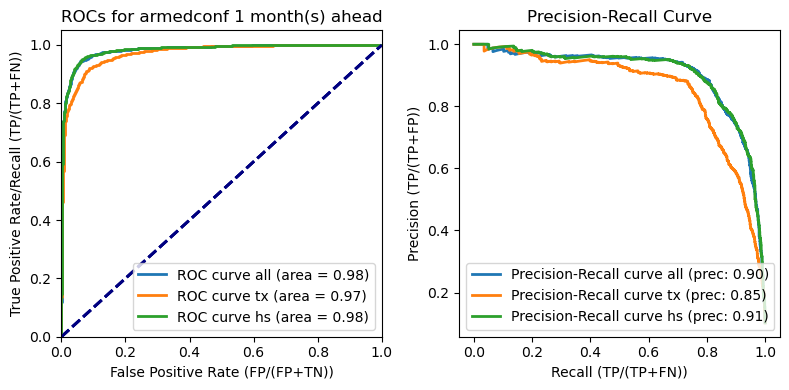

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: armedconf f3
Model: all
ROC: 0.974 Precision: 0.914

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.97     10225
         1.0       0.86      0.79      0.83      1595

    accuracy                           0.96     11820
   macro avg       0.92      0.89      0.90     11820
weighted avg       0.95      0.96      0.95     11820

Model: tx
ROC: 0.951 Precision: 0.832

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     10225
         1.0       0.85      0.65      0.74      1595

    accuracy                           0.94     11820
   macro avg       0.90      0.82      0.85     11820
weighted avg       0.93      0.94      0.93     11820

Model: hs
ROC: 0.976 Precision: 0.922

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97   

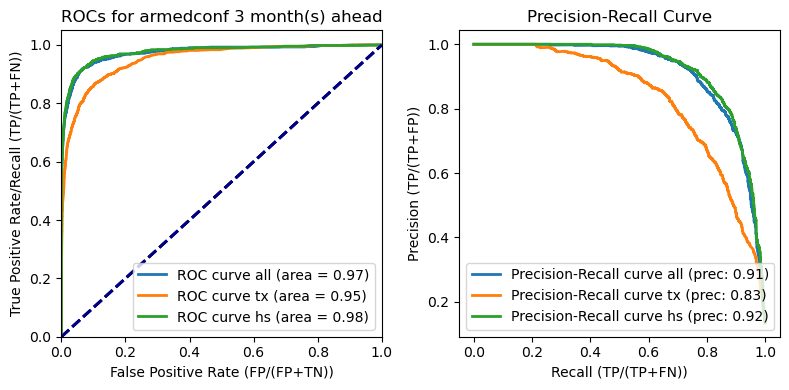

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: armedconf f6
Model: all
ROC: 0.956 Precision: 0.888

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      9429
         1.0       0.88      0.76      0.82      1800

    accuracy                           0.95     11229
   macro avg       0.92      0.87      0.89     11229
weighted avg       0.94      0.95      0.94     11229

Model: tx
ROC: 0.951 Precision: 0.859

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      9429
         1.0       0.87      0.68      0.76      1800

    accuracy                           0.93     11229
   macro avg       0.90      0.83      0.86     11229
weighted avg       0.93      0.93      0.93     11229

Model: hs
ROC: 0.962 Precision: 0.891

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96   

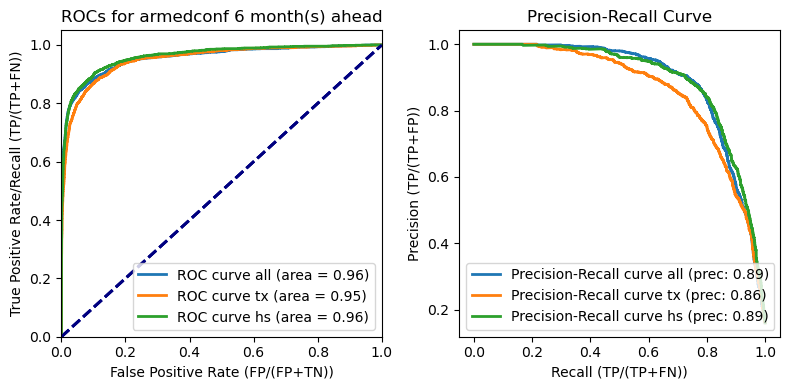

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: escalation f1
Model: all
ROC: 0.901 Precision: 0.383

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.87      0.92     11287
         1.0       0.32      0.72      0.44       927

    accuracy                           0.86     12214
   macro avg       0.65      0.80      0.68     12214
weighted avg       0.92      0.86      0.89     12214

Model: tx
ROC: 0.867 Precision: 0.264

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.85      0.91     11287
         1.0       0.27      0.67      0.38       927

    accuracy                           0.84     12214
   macro avg       0.62      0.76      0.64     12214
weighted avg       0.92      0.84      0.87     12214

Model: hs
ROC: 0.907 Precision: 0.429

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97  

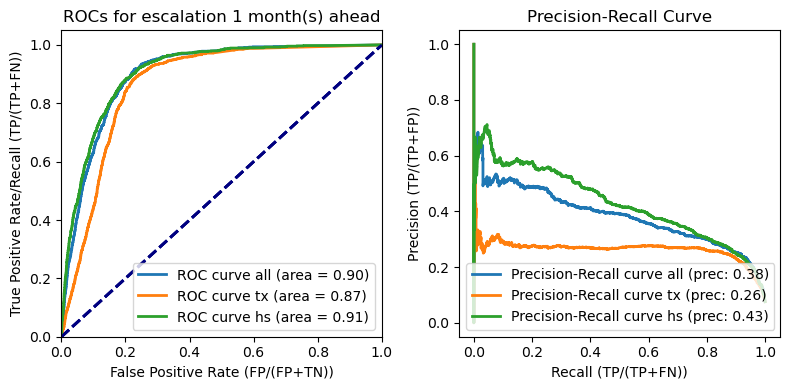

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: escalation f3
Model: all
ROC: 0.93 Precision: 0.691

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.88      0.92      9638
         1.0       0.62      0.88      0.73      2182

    accuracy                           0.88     11820
   macro avg       0.80      0.88      0.83     11820
weighted avg       0.91      0.88      0.89     11820

Model: tx
ROC: 0.917 Precision: 0.634

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.88      0.92      9638
         1.0       0.61      0.85      0.71      2182

    accuracy                           0.87     11820
   macro avg       0.79      0.86      0.81     11820
weighted avg       0.90      0.87      0.88     11820

Model: hs
ROC: 0.932 Precision: 0.718

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97   

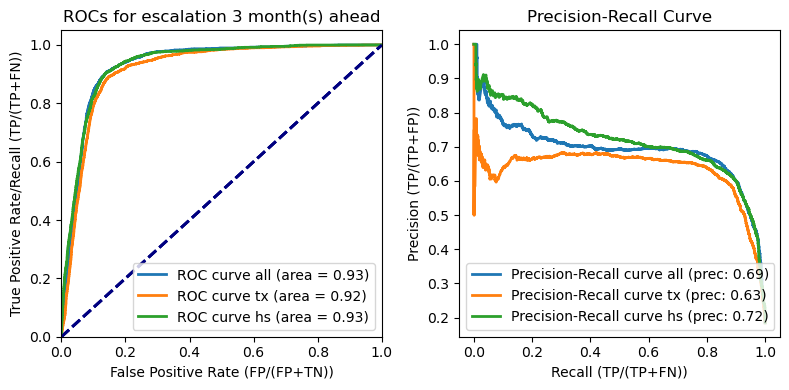

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: escalation f6
Model: all
ROC: 0.953 Precision: 0.857

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.91      0.93      8351
         1.0       0.77      0.88      0.82      2878

    accuracy                           0.90     11229
   macro avg       0.86      0.90      0.88     11229
weighted avg       0.91      0.90      0.91     11229

Model: tx
ROC: 0.927 Precision: 0.799

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.86      0.91      8351
         1.0       0.69      0.88      0.77      2878

    accuracy                           0.87     11229
   macro avg       0.82      0.87      0.84     11229
weighted avg       0.89      0.87      0.87     11229

Model: hs
ROC: 0.952 Precision: 0.867

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96  

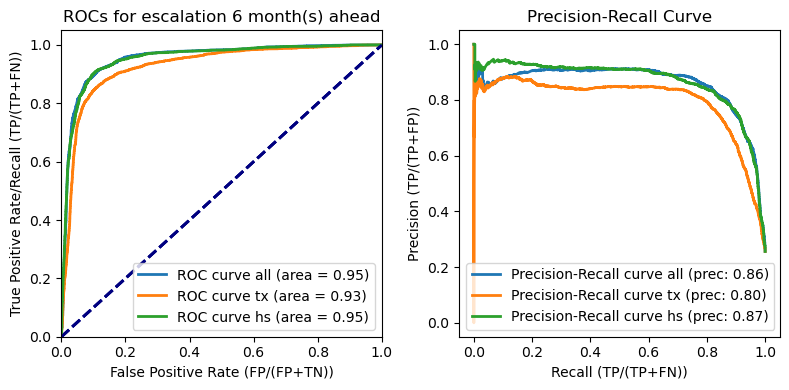

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: escalation f1
Model: all
ROC: 0.896 Precision: 0.418

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     11287
         1.0       0.51      0.27      0.35       927

    accuracy                           0.93     12214
   macro avg       0.73      0.62      0.66     12214
weighted avg       0.91      0.93      0.91     12214

Model: tx
ROC: 0.864 Precision: 0.262

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.98      0.96     11287
         1.0       0.25      0.06      0.10       927

    accuracy                           0.91     12214
   macro avg       0.59      0.52      0.53     12214
weighted avg       0.88      0.91      0.89     12214

Model: hs
ROC: 0.902 Precision: 0.444

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95  

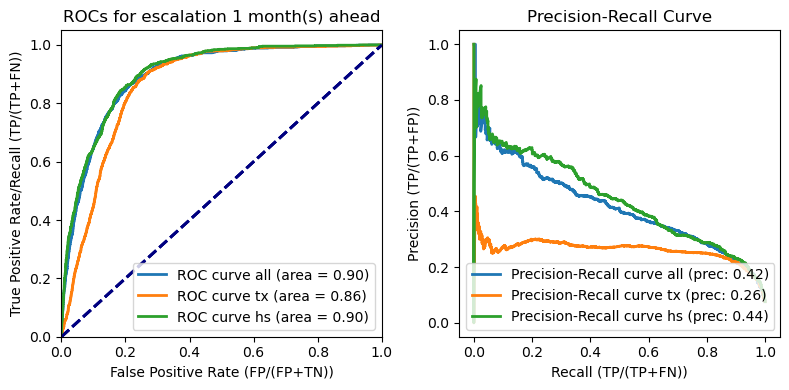

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: escalation f3
Model: all
ROC: 0.93 Precision: 0.709

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.92      0.93      9638
         1.0       0.68      0.76      0.72      2182

    accuracy                           0.89     11820
   macro avg       0.81      0.84      0.83     11820
weighted avg       0.90      0.89      0.89     11820

Model: tx
ROC: 0.915 Precision: 0.647

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.93      0.92      9638
         1.0       0.66      0.64      0.65      2182

    accuracy                           0.87     11820
   macro avg       0.79      0.78      0.78     11820
weighted avg       0.87      0.87      0.87     11820

Model: hs
ROC: 0.929 Precision: 0.714

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94   

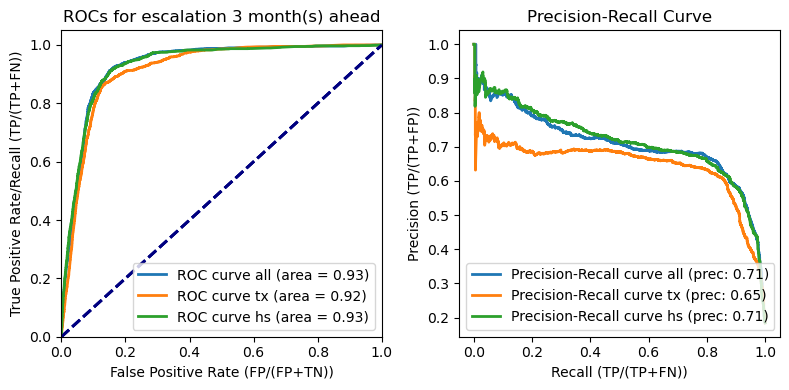

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: escalation f6
Model: all
ROC: 0.95 Precision: 0.86

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      8351
         1.0       0.87      0.78      0.82      2878

    accuracy                           0.91     11229
   macro avg       0.90      0.87      0.88     11229
weighted avg       0.91      0.91      0.91     11229

Model: tx
ROC: 0.947 Precision: 0.856

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      8351
         1.0       0.87      0.76      0.81      2878

    accuracy                           0.91     11229
   macro avg       0.90      0.86      0.88     11229
weighted avg       0.91      0.91      0.91     11229

Model: hs
ROC: 0.947 Precision: 0.853

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93    

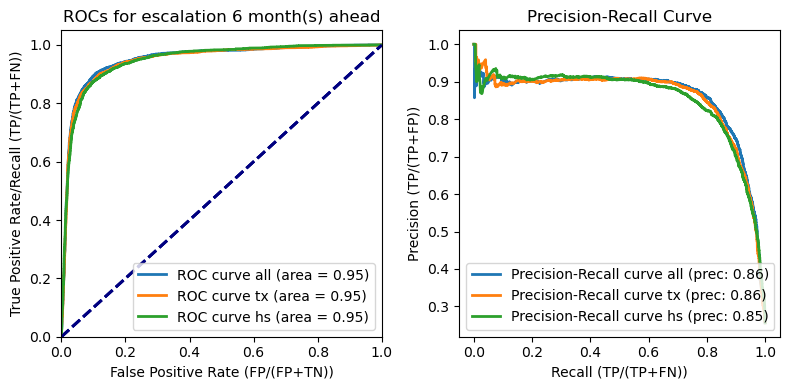

- - - - -- - - - - - - - - - - - - - - - - - - - - - 


In [21]:
for algo in algos:
    for target in ['armedconf']:
        for sft in [1,3,6]: #,2]:
            print('TARGET:', target, f'f{sft}') #, model)
            get_roc_pr(df, sft, target, ['all', 'tx', 'hs'], start_month_year, algo = algo)
            print('- - - - -- - - - - - - - - - - - - - - - - - - - - - ')

for algo in algos:
    for target in ['escalation']:
        for sft in [1,3,6]: #,2]:
            print('TARGET:', target, f'f{sft}') #, model)
            get_roc_pr(df, sft, target, ['all', 'tx', 'hs'], start_month_year, algo = algo)
            print('- - - - -- - - - - - - - - - - - - - - - - - - - - - ')

## Separation Plots (for classification)

Could be adapted for months since.

In [54]:
def separation_plot(pdata, fname, alpha=1):
    '''
    Display observed events against predicted probabilities for binary classification problems
    Arguments
    ---------
        y : vector of observed class labels
        yhat : vector of predicted probabilities
        fname: file path to directory to save plot 
        alpha: float from 0 to 1, transparency of indicators of observed events
    '''

    pdata.columns = ['y', 'yhat']
    pdata = pdata.sort_values('yhat')
    pdata = pdata.reset_index(drop=True)

    events = pdata[pdata['y'] == 1]
    evals = events.index.values

    fig = plt.figure(figsize=(20, 5))
    plt.ylabel('Predicted risk')
    ax = plt.gca()
    ax.set_xlim([1, (evals[-1] + 1)])
    ax.set_ylim([0, 1])
    
    rr = 0
    for i in evals:
        if rr == 0:
            ax.axvline(x=i, linewidth=0.2, linestyle='-', color='k', alpha=alpha, label = 'Increases', zorder=2)
            rr = 1
        else:
            ax.axvline(x=i, linewidth=0.2, linestyle='-', color='k', alpha=alpha, zorder=1)
    
    ax.plot(pdata['yhat'], linestyle='--', color='red', lw = 4, label = 'Predicted increase', zorder=3)
    ax.set_xlabel('Rank of prediction')
    ax.legend(loc="upper left")
    #plt.savefig(fname)
    plt.show()
    #fig.savefig(f'sep_plot_{target}_{algo}_f{forward}.png')
    plt.close() 

In [55]:
#monthsince as the key sufficient statistic - make sure you understand

def produce_stats(df, true_vals, pred_vals): #monthsince

    #drop any rows for which there are no predictions
    restricted=df.dropna(subset=[true_vals,f'{pred_vals}_all', f'{pred_vals}_hs', f'{pred_vals}_tx'])
    
    # IGNORED
    #only keep observations where there has been at least (0) months of peace
    #restricted=restricted[restricted["anyviolence_dp"]>=monthsince] #anyviolence_dp counts months of peace duration
    
    y_true=restricted[true_vals]

    # full model
    #y_scores=restricted[f'{pred_vals}_all']
    #print("observations:", len(y_scores))
    #print("full model AUC:", roc_auc_score(y_true.astype('int'), restricted[f'{pred_vals}_all']), "and av.precision:", average_precision_score(y_true.astype('int'), y_scores))

    # history model
    #y_scores=restricted[f'{pred_vals}_hs']
    #print("history model AUC:", roc_auc_score(y_true.astype('int'), restricted[f'{pred_vals}_hs']), "and av.precision:", average_precision_score(y_true.astype('int'), y_scores))

    # text model
    #y_scores=restricted[f'{pred_vals}_tx']
    #print("text model AUC:", roc_auc_score(y_true.astype('int'), restricted[f'{pred_vals}_tx']), "and av.precision:", average_precision_score(y_true.astype('int'), y_scores))

    # Print separation plots
    print("")

    print('Full model separation plot:')
    sep_data=restricted[[true_vals,f'{pred_vals}_all']]
    #name=Path(spitout + "{}_separation_plot.pdf".format(model_fitted))
    separation_plot(sep_data, 'name')

    print('History model separation plot:')
    sep_data=restricted[[true_vals,f'{pred_vals}_hs']]
    #name=Path(spitout + "{}_separation_plot.pdf".format(model_fitted))
    separation_plot(sep_data, 'name')

    print('Text model separation plot:')
    sep_data=restricted[[true_vals,f'{pred_vals}_tx']]
    #name=Path(spitout + "{}_separation_plot.pdf".format(model_fitted))
    separation_plot(sep_data, 'name')
    

-----------------------------------------------------------------------------------------
STATISTICS FOR TAGRET armedconf, predicting 1 month(s) ahead

Full model separation plot:


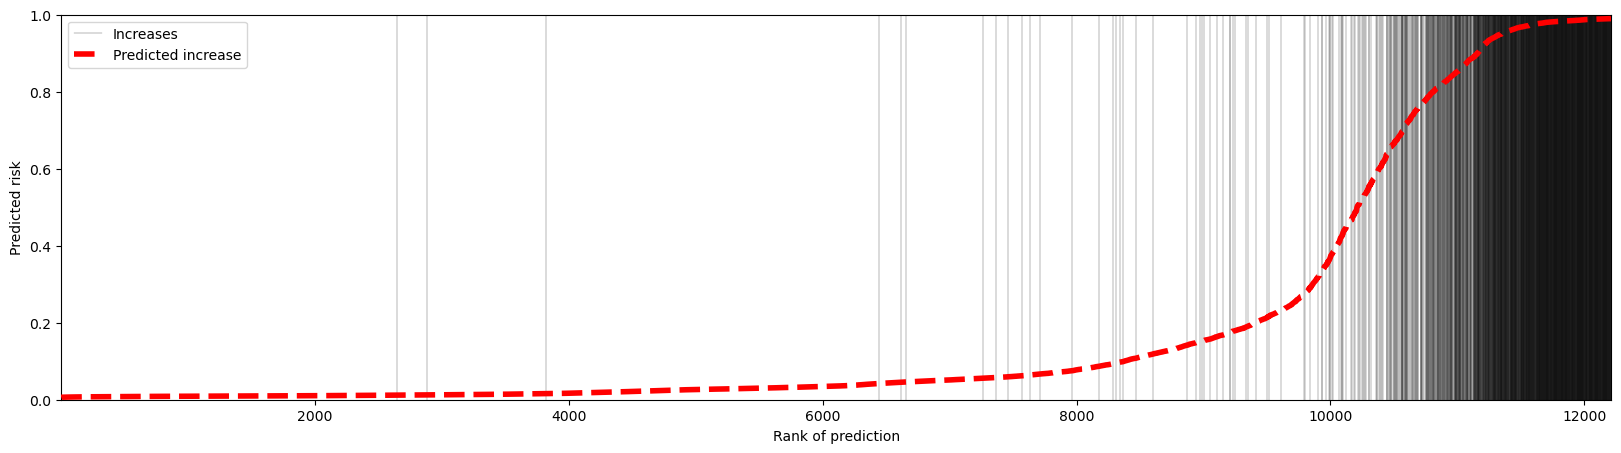

History model separation plot:


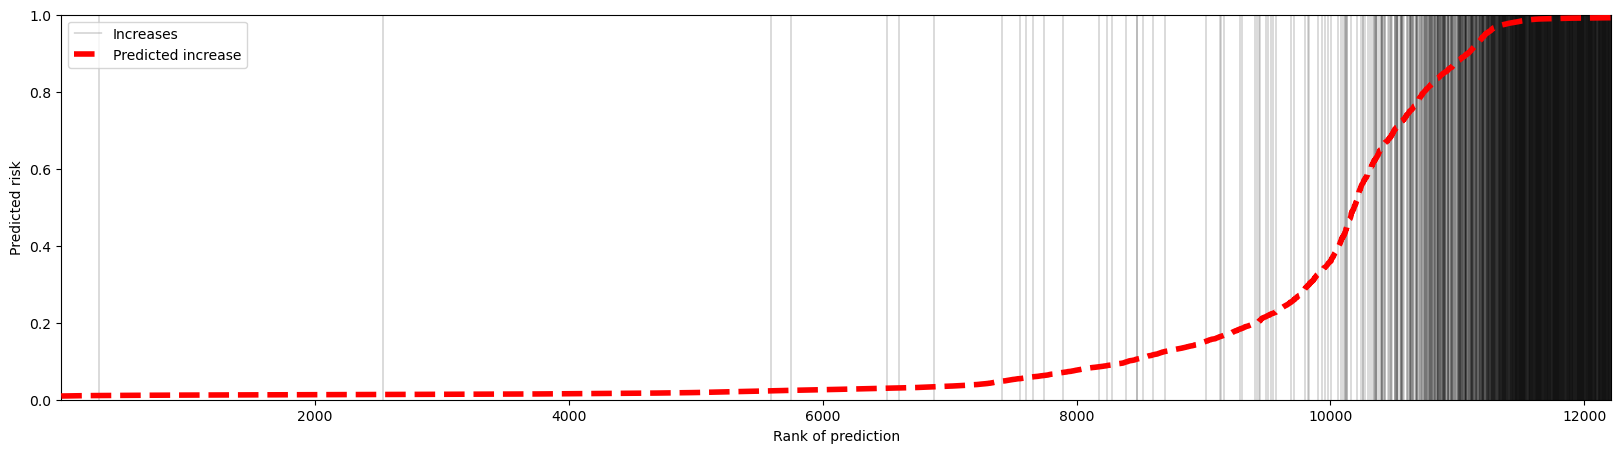

Text model separation plot:


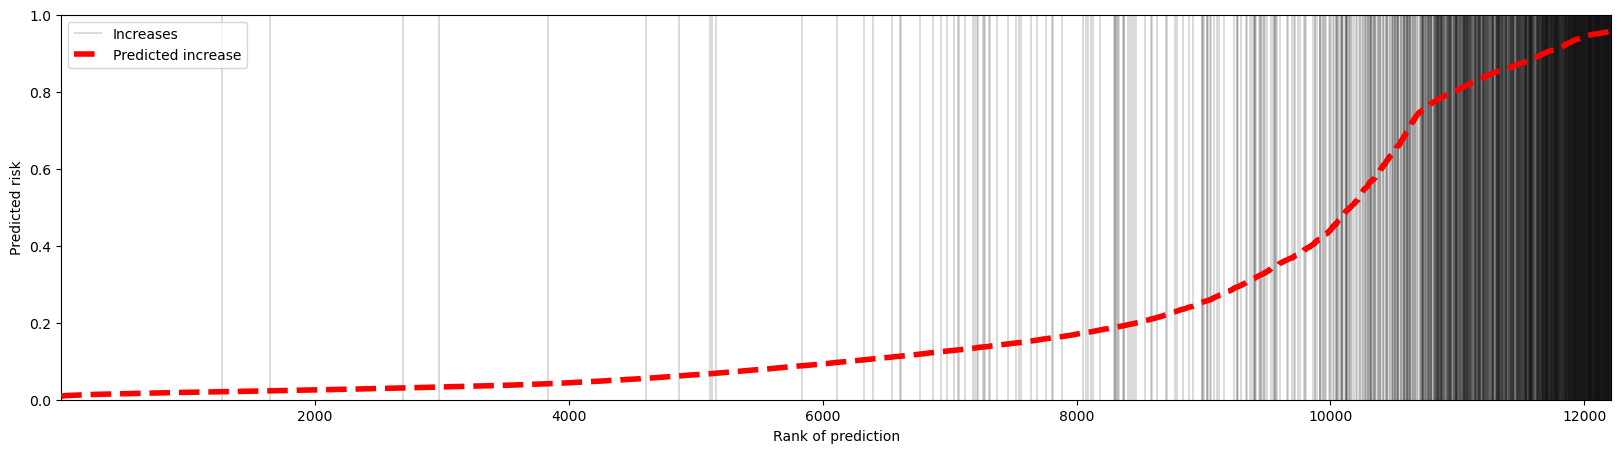

In [56]:
plot_targtes = ['armedconf']
plot_ffwds = [1]

algo = 'rf'
for target in plot_targtes:
    for forward in plot_ffwds:
        print('-----------------------------------------------------------------------------------------')
        print(f'STATISTICS FOR TAGRET {target}, predicting {forward} month(s) ahead')
        produce_stats(df, f'{target}_f{forward}', f'pred_{target}_{algo}_f{forward}')

## Root mean squared error (for regression)

In [57]:
fwds = [1,3,6]
models = ['all', 'hs', 'tx']

start_date = start_month_year #start_date ##start_date = dt.datetime(2018, 1, 2)

errors = {}

for algo in algos: 
    print('ALGORITHM:', algo)
    
    for model in models:

        for fwd in fwds:
                
                # get_tar_pred(df: pd.DataFrame() , fwd: int, model: str, start_time: dt, target: str, algo: str):
                y_trues, y_preds = get_tar_pred(df, fwd, model, start_date, target_regr, algo)
            
                errors[f'{model}_{fwd}'] = mean_squared_error(y_trues, y_preds)

    print('All Root Mean Squared Errors:')
    print(pd.Series(errors)) #.sort_values()

ALGORITHM: rf
All Root Mean Squared Errors:
all_1    0.623561
all_3    0.494066
all_6    0.374951
hs_1     0.620274
hs_3     0.490628
hs_6     0.372199
tx_1     0.957990
tx_3     0.717658
tx_6     0.590892
dtype: float64
ALGORITHM: xgb
All Root Mean Squared Errors:
all_1    0.631231
all_3    0.418932
all_6    0.339972
hs_1     0.587219
hs_3     0.405162
hs_6     0.352180
tx_1     0.860619
tx_3     0.623758
tx_6     0.511467
dtype: float64


## Plots by country for inspection

In [103]:
# pick country, forecast horizon and model
country = 'LKA'
#'SSD', BFA, LKA (srilanka), MMR (myanmar), IRQ (iraq), ETH (ethiopia), COD (congo), AFG (afghanistan), SOM (somalia), SYR (syria), UKR (ukraine), YEM (yemen), VEN (venezuela), ZWE (zimbabwe), VNM (vietnam), TUR (turkey), SDN (sudan), PAK (pakistan), NGA (nigeria), MEX (mexico), LBY (libya), IND (india), IDN (indonesia), EGY (egypt), COL (colombia), CAF (central african republic), BDI (burundi), BGD (bangladesh), BOL (bolivia), CMR (cameroon), CIV (cote d'ivoire), DZA (algeria), ECU (ecuador), GIN (guinea), HTI (haiti), KEN (kenya), LBN (lebanon), MDG (madagascar), MLI (mali), MOZ (mozambique), NER (niger), PHL (philippines), PRY (paraguay), RWA (rwanda), SLE (sierra leone), TCD (chad), TGO (togo), TUN (tunisia), UGA (uganda), ZMB (zambia), ZAF (south africa), TZA (tanzania), THA (thailand), SWE (sweden), NOR (norway), NLD (netherlands), MYS (malaysia), LUX (luxembourg), KOR (south korea), JPN (japan), ITA (italy), IRL (ireland), ISL (iceland), HUN (hungary), GRC (greece), GBR (united kingdom), FRA (france), FIN (finland), ESP (spain), DNK (denmark), DEU (germany), CZE (czech republic), CAN (canada), BEL (belgium), AUT (austria), AUS (australia), ARG (argentina), USA (united states), CHE (switzerland), CHL (chile), BRA (brazil), POL (poland), PRT (portugal), NZL (new zealand), MEX (
forward = 1

# get country df
country_name = pc.countries.get(alpha_3=country)
country_clsf =  df[df.isocode == country]

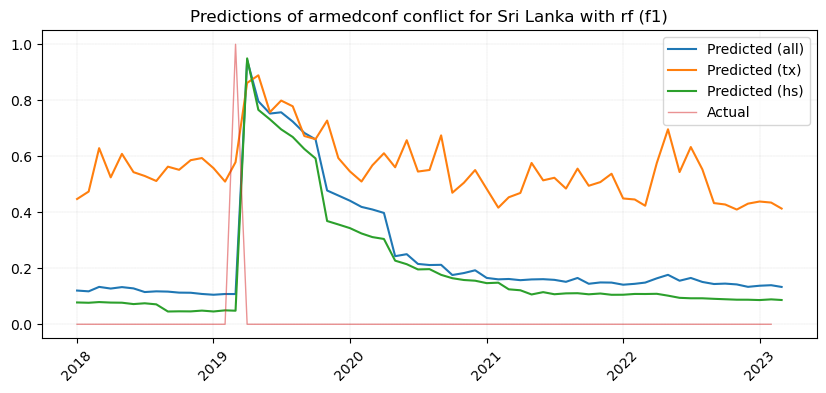

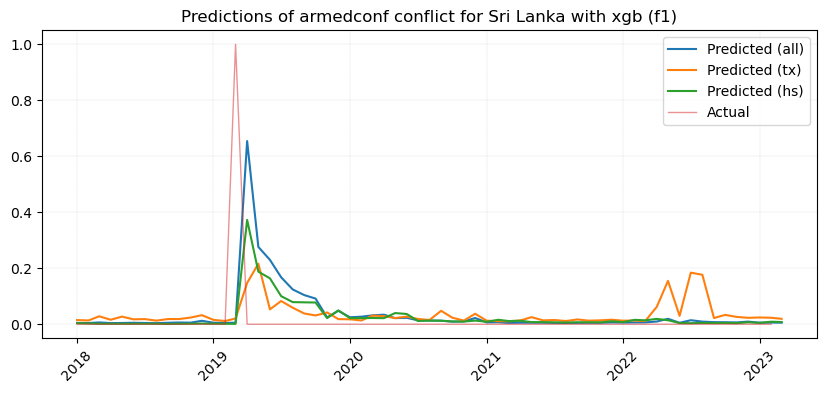

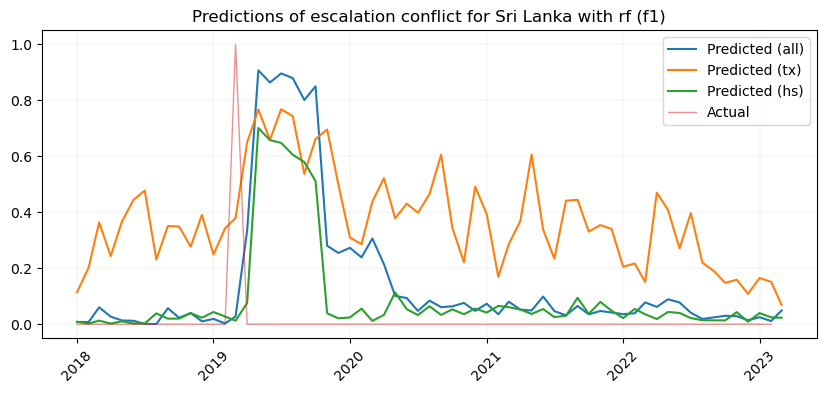

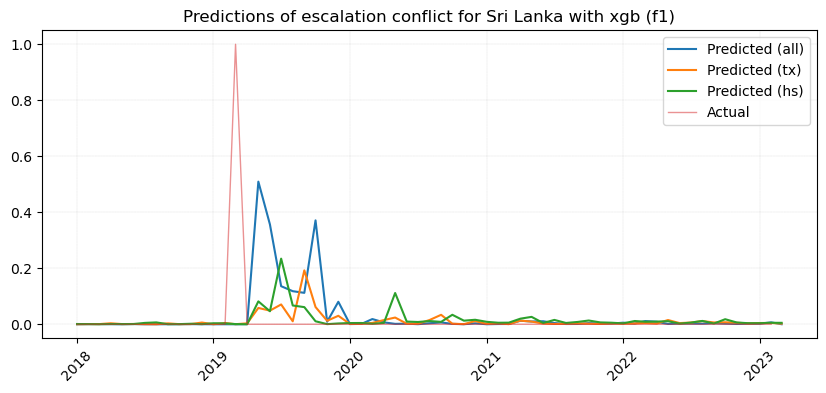

In [111]:
# plots for classification targets
for target in clsf_targets:
    for algo in algos:
        fig = plt.figure(figsize=(10,4)) 

        for model in ['all', 'tx', 'hs']:
            plt.plot(country_clsf.month_year,country_clsf[f'pred_{target}_{algo}_f{forward}_{model}'], label = f'Predicted ({model})')

        plt.plot(country_clsf.month_year,country_clsf[f'{target}_f{forward}'], linewidth=1, label = 'Actual', alpha=0.5)
        
        plt.title(f'Predictions of {target} conflict for {country_name.name} with {algo} (f{forward})')
        plt.legend()
        
        plt.grid(color='grey', linestyle='--', linewidth=0.1)
        plt.xticks(rotation=45)
        plt.show()

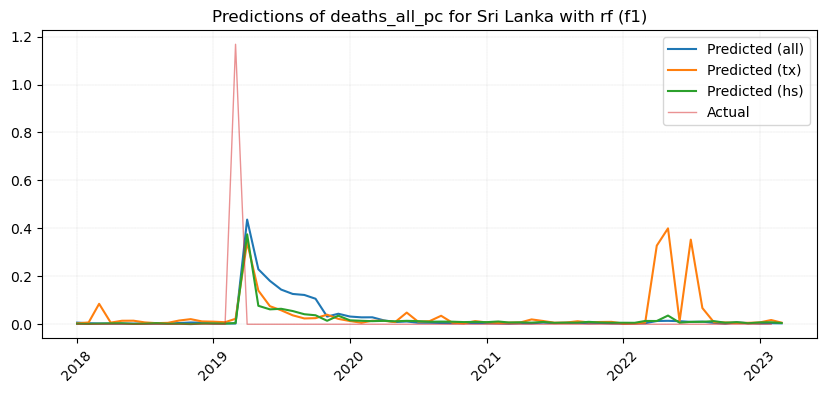

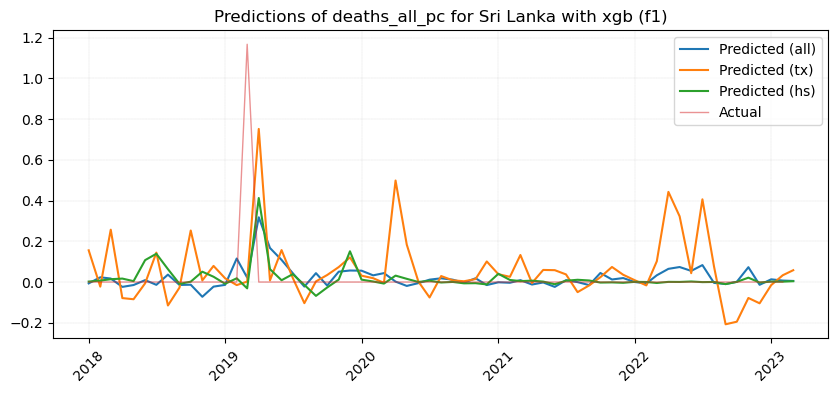

In [105]:
# plots for regression targets

for algo in algos:
    plt.figure(figsize=(10,4))


    for model in ['all', 'tx', 'hs']:
        plt.plot(country_clsf.month_year,country_clsf[f'pred_{target_regr}_{algo}_f{forward}_{model}'], label = f'Predicted ({model})')

    plt.plot(country_clsf.month_year,country_clsf[f'{target_regr}_f{forward}'], linewidth=1, label = 'Actual', alpha=0.5)

    plt.title(f'Predictions of {target_regr} for {country_name.name} with {algo} (f{forward})')
    plt.legend()
    plt.grid(color='grey', linestyle='--', linewidth=0.1)
    plt.xticks(rotation=45)
    plt.show()

## Metrics for Naive Baseline Model
This model simply predicts that the future month(s) will be like the current month.

### Data prep
The difficulty was that in order to compare like with like, we needed to ensure that for the evaluation of the f3 and f6 models, the final 3 and 6 rows are dropped. In the original code, the make_target function generate NaN values, for which the rows are dropped. Here we need to 'artificially' drop the correct number of rows. In order to match the logic of our existing functions we also generate the different 'f1' etc names (and put an 'n' for the algorithm) even though the values are always the same.

In [127]:
# create naive predctions 1 month ahead
df_nv1 = df.copy()
forward = [1]
for i in forward:
    df_nv1[f'pred_{target_conf}_n_f{i}_nv'] = df_nv1.groupby(unit_of_analyis)[target_conf].shift(i)
    df_nv1[f'pred_{target_escl}_n_f{i}_nv'] = df_nv1.groupby(unit_of_analyis)[target_escl].shift(i)
    df_nv1[f'pred_{target_regr}_n_f{i}_nv'] = df_nv1.groupby(unit_of_analyis)[target_regr].shift(i) 
    # drop the final month for each country (the attempt to fill them with NaN did not work)
    df_nv1 = df_nv1.groupby(unit_of_analyis).apply(lambda x: x.iloc[:-(i)])
     #df_nv1[f'pred_{target_regr}__f{i}_nv'] = df_nv1.groupby(unit_of_analyis)[f'pred_{target_regr}__f{i}_nv'].transform(lambda x: x if x.name != x.index[-i] else np.nan)
df_nv1.reset_index(drop=True, inplace=True)


# create naive predctions 3 months ahead (using the 1 month ahead predictions)
df_nv2 = df_nv1.copy()
forward = [3]
for i in forward:
    df_nv2[f'pred_{target_conf}_n_f{i}_nv'] = df_nv2[f'pred_{target_conf}_n_f1_nv']
    df_nv2[f'pred_{target_escl}_n_f{i}_nv'] = df_nv2[f'pred_{target_escl}_n_f1_nv']
    df_nv2[f'pred_{target_regr}_n_f{i}_nv'] = df_nv2[f'pred_{target_regr}_n_f1_nv']   
    df_nv2 = df_nv2.groupby(unit_of_analyis).apply(lambda x: x.iloc[:-(i-1)]) # don't drop three rows as one already dropped above
df_nv2.reset_index(drop=True, inplace=True)

# create naive predctions 6 months ahead (using the 1 month ahead predictions)
df_nv_all = df_nv2.copy()
forward = [6]
for i in forward:
    df_nv_all[f'pred_{target_conf}_n_f{i}_nv'] = df_nv_all[f'pred_{target_conf}_n_f1_nv']
    df_nv_all[f'pred_{target_escl}_n_f{i}_nv'] = df_nv_all[f'pred_{target_escl}_n_f1_nv']
    df_nv_all[f'pred_{target_regr}_n_f{i}_nv'] = df_nv_all[f'pred_{target_regr}_n_f1_nv']
    df_nv_all = df_nv_all.groupby(unit_of_analyis).apply(lambda x: x.iloc[:-(i-3)]) # don't drop six rows as three already dropped above
df_nv_all.reset_index(drop=True, inplace=True)

In [129]:
# check if right columns were dropped

#df_nv1.loc[df_nv1['isocode'] == 'AFG', ['isocode', 'month_year','pred_armedconf_n_f1_nv']][-4:]
df_nv2.loc[df_nv2['isocode'] == 'AFG', ['isocode', 'month_year','pred_armedconf_n_f3_nv']][-4:]
#df_nv_all.loc[df_nv_all['isocode'] == 'AFG', ['isocode', 'month_year','pred_armedconf__f6_nv']]#[-4:]

,isocode,month_year,pred_armedconf_n_f3_nv
56,AFG,2022-09-01,True
57,AFG,2022-10-01,True
58,AFG,2022-11-01,True
59,AFG,2022-12-01,True


### ROC and precision re-call curves (for classification baseline)

Model: nv
ROC: 0.884 Precision: 0.651

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     10780
         1.0       0.79      0.79      0.79      1237

    accuracy                           0.96     12017
   macro avg       0.89      0.88      0.88     12017
weighted avg       0.96      0.96      0.96     12017



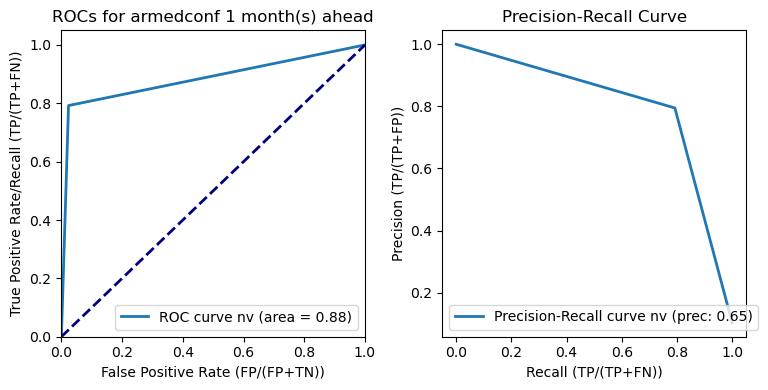

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
Model: nv
ROC: 0.837 Precision: 0.657

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     10051
         1.0       0.90      0.69      0.78      1572

    accuracy                           0.95     11623
   macro avg       0.92      0.84      0.87     11623
weighted avg       0.94      0.95      0.94     11623



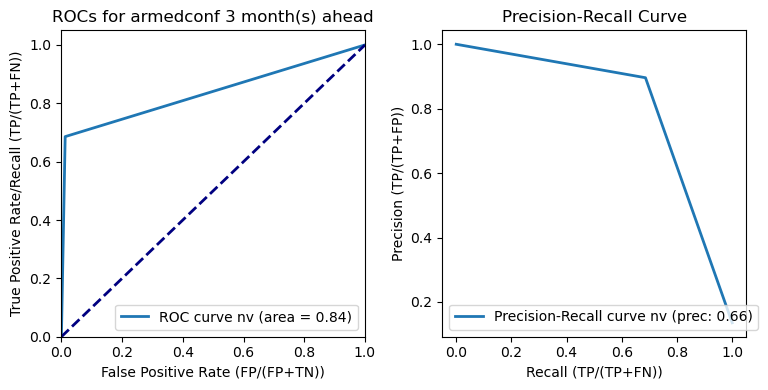

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
Model: nv
ROC: 0.792 Precision: 0.619

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      9258
         1.0       0.93      0.59      0.72      1774

    accuracy                           0.93     11032
   macro avg       0.93      0.79      0.84     11032
weighted avg       0.93      0.93      0.92     11032



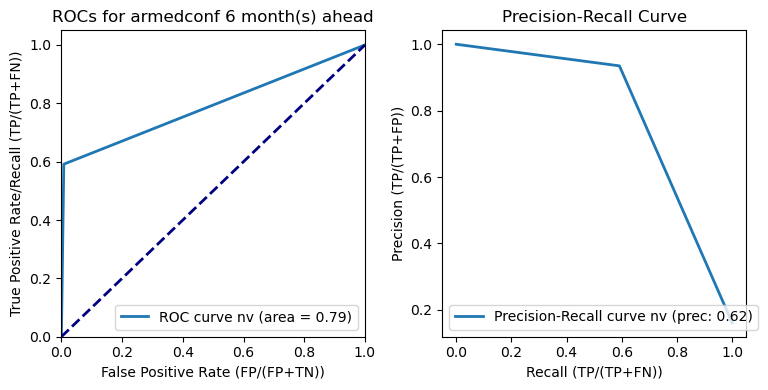

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
Model: nv
ROC: 0.613 Precision: 0.136

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     11104
         1.0       0.29      0.28      0.29       913

    accuracy                           0.89     12017
   macro avg       0.61      0.61      0.61     12017
weighted avg       0.89      0.89      0.89     12017



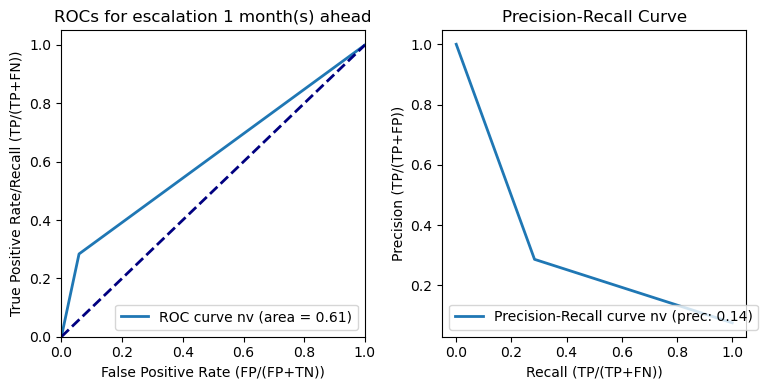

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
Model: nv
ROC: 0.62 Precision: 0.313

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.97      0.91      9478
         1.0       0.66      0.27      0.38      2145

    accuracy                           0.84     11623
   macro avg       0.76      0.62      0.65     11623
weighted avg       0.82      0.84      0.81     11623



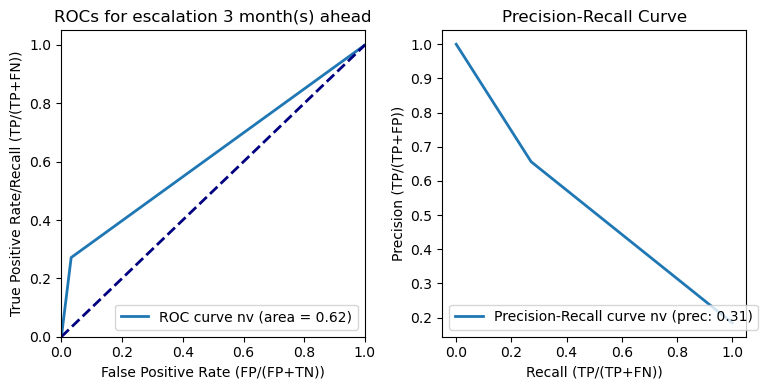

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
Model: nv
ROC: 0.617 Precision: 0.403

Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.98      0.88      8201
         1.0       0.84      0.25      0.38      2831

    accuracy                           0.80     11032
   macro avg       0.82      0.62      0.63     11032
weighted avg       0.81      0.80      0.75     11032



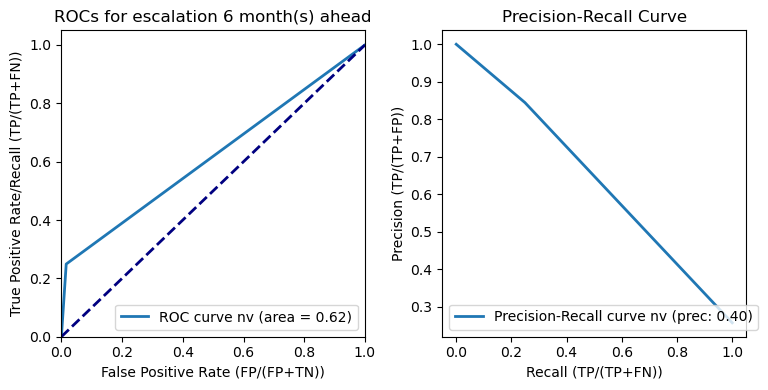

- - - - -- - - - - - - - - - - - - - - - - - - - - - 


In [131]:
#get_tar_pred(df_nv, 1, model: 'nv', start_time: dt, target: str, type: str):

#get_roc_pr(df_og = df_nv, fwd = 1, target: str, models: list, staryearid, binary=True, plot=True):

fwds = [1,3,6]

for target in ['armedconf', 'escalation']:
    for sft in fwds:
        #print(target, f'f_{sft}') #, model)
        # et_roc_pr(df, sft, target, ['all', 'tx', 'hs'], start_month_year, algo = algo)
        if sft == 1:
            get_roc_pr(df_nv1, sft, target, ['nv'], start_month_year, algo= 'n')
            
        elif sft == 3:
            get_roc_pr(df_nv2, sft, target, ['nv'], start_month_year, algo= 'n')
        elif sft == 6:
            get_roc_pr(df_nv_all, sft, target, ['nv'], start_month_year, algo= 'n')

        print('- - - - -- - - - - - - - - - - - - - - - - - - - - - ')

### Root mean squared error (for regression baseline)

In [134]:
errors = {}
for fwd in fwds:
#    for model in models:
            
            y_trues, y_preds = get_tar_pred(df_nv_all, fwd, 'nv', start_month_year, target_regr, 'n')
        
            errors[f'nv_{fwd}'] = mean_squared_error(y_trues, y_preds)

print('All Root Mean Squared Errors:')
print(pd.Series(errors)) #.sort_values()

All Root Mean Squared Errors:
nv_1    1.169084
nv_3    0.935629
nv_6    0.838287
dtype: float64
